### Dependencies

In [8]:
%pip install -q python-dotenv networkx pyvis text_unidecode


Note: you may need to restart the kernel to use updated packages.


### Imports (prefer to move imports to first use)

In [9]:
import warnings
warnings.filterwarnings('ignore')

from text_unidecode import unidecode
from collections import deque
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from node2vec import Node2Vec

sns.set_style('whitegrid')


### Data loading and pre processing

In [10]:
# Load data 
data = pd.read_csv('./data/FullData.csv', usecols=['Name', 'Club', 'Club_Position', 'Rating'])

# Lowercase columns for convenience
data.columns = list(map(str.lower, data.columns))

# Reformat strings: lowercase, ' ' -> '_' and é, ô etc. -> e, o
reformat_string = lambda x: unidecode(str.lower(x).replace(' ', '_'))
    
data['name'] = data['name'].apply(reformat_string)
data['club'] = data['club'].apply(reformat_string)

# Lowercase position
data['club_position'] = data['club_position'].str.lower()

# Starting 11 only
data = data[(data['club_position'] != 'sub') & (data['club_position'] != 'res')]

# Simplify position
fix_positions = {'rcm' : 'cm', 'lcm': 'cm', 'rcb': 'cb', 'lcb': 'cb', 'ldm': 'cdm', 'rdm': 'cdm'}
data['club_position'] = data['club_position'].apply(lambda x: fix_positions.get(x, x))

# Sample 7 clubs
clubs = {'real_madrid', 'manchester_utd', 
         'manchester_city', 'chelsea', 'juventus', 
         'fc_bayern', 'napoli'}

data = data[data['club'].isin(clubs)]

# Assert 11 player per club
assert all(n_players == 11 for n_players in data.groupby('club')['name'].nunique())
print(data.shape)


(77, 4)


In [11]:
FORMATIONS = {'4-3-3_4': {'gk': ['cb_1', 'cb_2'],                           # Real madrid
                          'lb': ['lw', 'cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk'],
                          'cb_2': ['rb', 'cb_1', 'gk'],
                          'rb': ['rw', 'cb_2', 'cm_2'],
                          'cm_1': ['cam', 'lw', 'cb_1', 'lb'],
                          'cm_2': ['cam', 'rw', 'cb_2', 'rb'],
                          'cam': ['cm_1', 'cm_2', 'st'],
                          'lw': ['cm_1', 'lb', 'st'],
                          'rw': ['cm_2', 'rb', 'st'],
                          'st': ['cam', 'lw', 'rw']},
              '5-2-2-1': {'gk': ['cb_1', 'cb_2', 'cb_3'],                   # Chelsea
                          'cb_1': ['gk', 'cb_2', 'lwb'],
                          'cb_2': ['gk', 'cb_1', 'cb_3', 'cm_1', 'cb_2'],
                          'cb_3': ['gk', 'cb_2', 'rwb'],
                          'lwb': ['cb_1', 'cm_1', 'lw'],
                          'cm_1': ['lwb', 'cb_2', 'cm_2', 'lw', 'st'],
                          'cm_2': ['rwb', 'cb_2', 'cm_1', 'rw', 'st'],
                          'rwb': ['cb_3', 'cm_2', 'rw'],
                          'lw': ['lwb', 'cm_1', 'st'],
                          'st': ['lw', 'cm_1', 'cm_2', 'rw'],
                          'rw': ['st', 'rwb', 'cm_2']},
              '4-3-3_2': {'gk': ['cb_1', 'cb_2'],                           # Man UTD / CITY
                          'lb': ['cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk', 'cdm'],
                          'cb_2': ['rb', 'cb_1', 'gk', 'cdm'],
                          'rb': ['cb_2', 'cm_2'],
                          'cm_1': ['cdm', 'lw', 'lb', 'st'],
                          'cm_2': ['cdm', 'rw', 'st', 'rb'],
                          'cdm': ['cm_1', 'cm_2', 'cb_1', 'cb_2'],
                          'lw': ['cm_1', 'st'],
                          'rw': ['cm_2', 'st'],
                          'st': ['cm_1', 'cm_2', 'lw', 'rw']},              # Juventus, Bayern
              '4-2-3-1_2': {'gk': ['cb_1', 'cb_2'],
                            'lb': ['lm', 'cdm_1', 'cb_1'],
                            'cb_1': ['lb', 'cdm_1', 'gk', 'cb_2'],
                            'cb_2': ['rb', 'cdm_2', 'gk', 'cb_1'],
                            'rb': ['cb_2', 'rm', 'cdm_2'],
                            'lm': ['lb', 'cdm_1', 'st', 'cam'],
                            'rm': ['rb', 'cdm_2', 'st', 'cam'],
                            'cdm_1': ['lm', 'cb_1', 'rb', 'cam'],
                            'cdm_2': ['rm', 'cb_2', 'lb', 'cam'],
                            'cam': ['cdm_1', 'cdm_2', 'rm', 'lm', 'st'],
                            'st': ['lm', 'rm', 'cam']},
              '4-3-3': {'gk': ['cb_1', 'cb_2'],                             # Napoli
                        'lb': ['cb_1', 'cm_1'],
                        'cb_1': ['lb', 'cb_2', 'gk', 'cm_2'],
                        'cb_2': ['rb', 'cb_1', 'gk', 'cm_2'],
                        'rb': ['cb_2', 'cm_3'],
                        'cm_1': ['cm_2', 'lw', 'lb'],
                        'cm_3': ['cm_2', 'rw', 'rb'],
                        'cm_2': ['cm_1', 'cm_3', 'st', 'cb_1', 'cb_2'],
                        'lw': ['cm_1', 'st'],
                        'rw': ['cm_3', 'st'],
                        'st': ['cm_2', 'lw', 'rw']}}


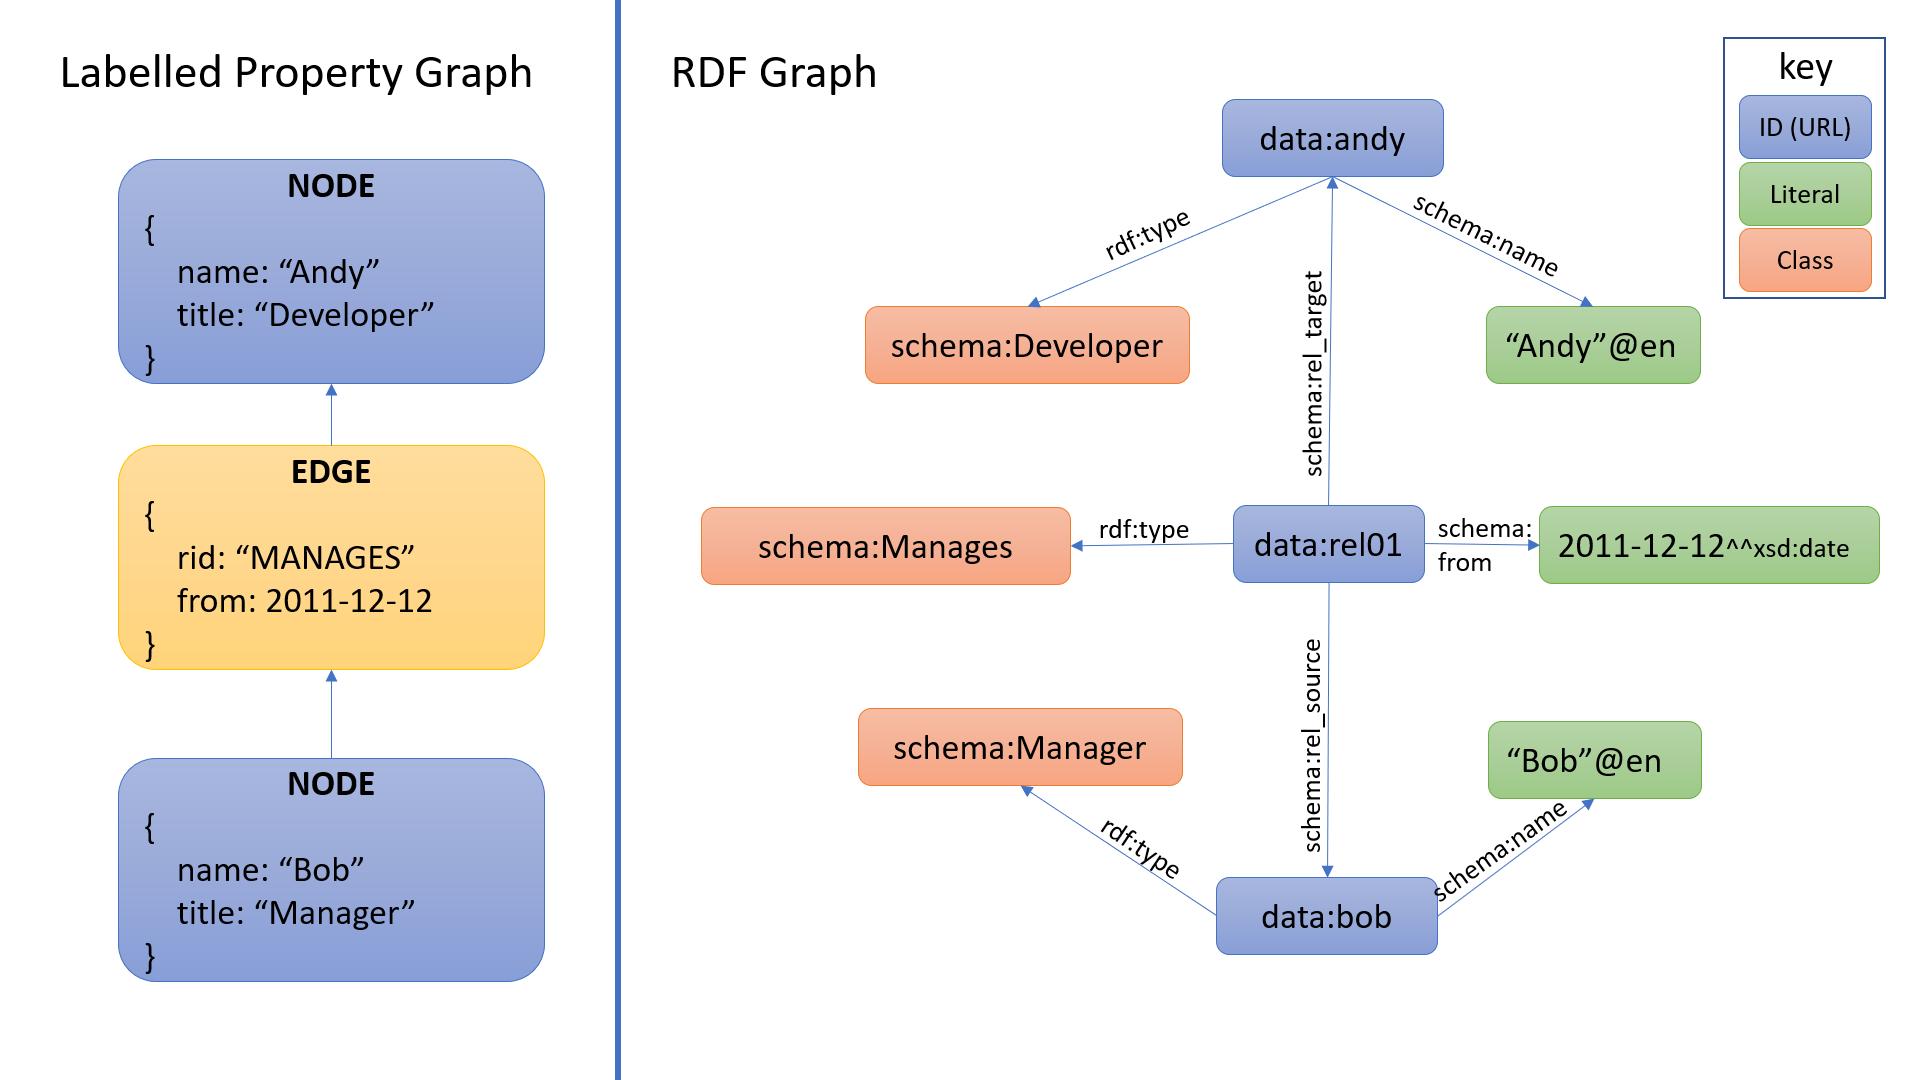

### Graph Generator

In [12]:
import networkx as nx
add_club_suffix = lambda x, c: x + '_{}'.format(c)
graph = nx.Graph()
formatted_positions = set()
    
def club2graph(club_name, formation):

    club_data = data[data['club'] == club_name]
    club_formation = FORMATIONS[formation]
    club_positions = dict()
    
    # Assign positions to players
    available_positions = deque(club_formation)
    available_players = set(zip(club_data['name'], club_data['club_position']))    
    roster = dict()  
    
    while available_positions:
        position = available_positions.pop()
        name, pos = [(name, position) for name, p in available_players if position.startswith(p)][0]            
        roster[name] = pos
        available_players.remove((name, pos.split('_')[0]))
        
    reverse_roster = {v: k for k, v in roster.items()}
        
    # Build the graph
    for name, position in roster.items():                
        graph.add_node(name, type='Player')
        graph.add_node(club_name, type='Club')
        graph.add_edge(name, club_name)
        # Inter team connections
        for teammate_position in club_formation[position]:
            # Connect positions
            graph.add_edge(position, teammate_position, relation="connects_with")
            
            # Connect player to teammate positions
            graph.add_edge(name, position, relation="plays_postion")
            
            # Connect player to teammates
            graph.add_edge(name, reverse_roster[teammate_position], relation="interacts_with")
            
            # Save for later trimming
            formatted_positions.add(position)
            formatted_positions.add(teammate_position)
            
    return graph


### Build single graph

In [13]:
teams = [('real_madrid', '4-3-3_4'), 
         ('chelsea', '5-2-2-1'),
         ('manchester_utd', '4-3-3_2'),
         ('manchester_city', '4-3-3_2'),
         ('juventus', '4-2-3-1_2'),
         ('fc_bayern', '4-2-3-1_2'),
         ('napoli', '4-3-3')]

for team, formation in teams:
    graph = club2graph(team, formation)

nx.write_graphml(graph, 'data/graph.graphml')


### Fun with PyVis

In [7]:
# Create a PyVis Network object
from pyvis.network import Network
net = Network(notebook=True,cdn_resources='in_line',
  bgcolor = "#222222",
                font_color = "white",
                height = "750px",
                width = "100%")
# Convert the NetworkX graph to a PyVis graph
net.from_nx(graph)

# Add the relation attribute as edge labels
for u, v, g in graph.edges(data=True):
    net.add_edge(u, v, title="XXX", lable='YYY')

# Render the graph in the Jupyter notebook
net.show_buttons() 
net.show("graph.html")


graph.html


### Save to disk

In [9]:
nx.write_graphml(graph, "fifa.graphml")


In [12]:
for node, attr in graph.nodes(data=True):
    if attr and attr.get("type") == "Player":
        print(node)


karim_benzema
james_rodriguez
cristiano_ronaldo
gareth_bale
luka_modric
carvajal
toni_kroos
marcelo
sergio_ramos
pepe
keylor_navas
pedro
diego_costa
victor_moses
n'golo_kante
eden_hazard
nemanja_matic
marcos_alonso
david_luiz
gary_cahill
azpilicueta
thibaut_courtois
zlatan_ibrahimovic
ander_herrera
paul_pogba
anthony_martial
henrikh_mkhitaryan
michael_carrick
eric_bailly
chris_smalling
antonio_valencia
daley_blind
de_gea
sergio_aguero
kevin_de_bruyne
david_silva
leroy_sane
raheem_sterling
yaya_toure
john_stones
nicolas_otamendi
bacary_sagna
gael_clichy
willy_caballero
gonzalo_higuain
mario_mandzukic
juan_cuadrado
paulo_dybala
sami_khedira
miralem_pjanic
leonardo_bonucci
alex_sandro
giorgio_chiellini
stephan_lichtsteiner
gianluigi_buffon
robert_lewandowski
douglas_costa
arjen_robben
thomas_muller
arturo_vidal
thiago
javi_martinez
david_alaba
mats_hummels
philipp_lahm
manuel_neuer
dries_mertens
amadou_diawara
lorenzo_insigne
jose_callejon
piotr_zielinski
marek_hamsik
kalidou_koulibaly
ra

In [17]:
[print(f"Node: {node}, Attributes: {attr}")for node, attr in graph.nodes(data=True)if attr.get("Type") == "Club"]


[]

In [12]:
players


[]